This notebook is the part of the coursework from the Deep Learning School. The aim of this task was to train the model for the segmentation of moles

---


1. Dataset loading: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>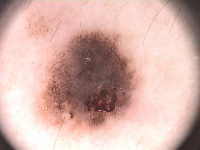</td><td>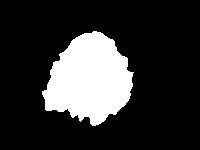</td></tr></table>


It contains photos of two types of **skin lesions:** melanoma and moles.

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

To make sure everything is correct, we will draw some images

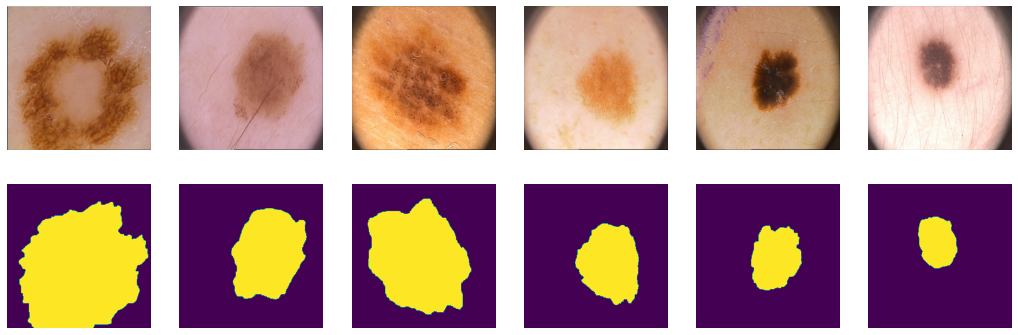

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Let's take 100/50/50 for training, validation and testing accordingly

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


italicized text-----------------------------------------------------------------------------------------
# SegNet reaization [2 балла]

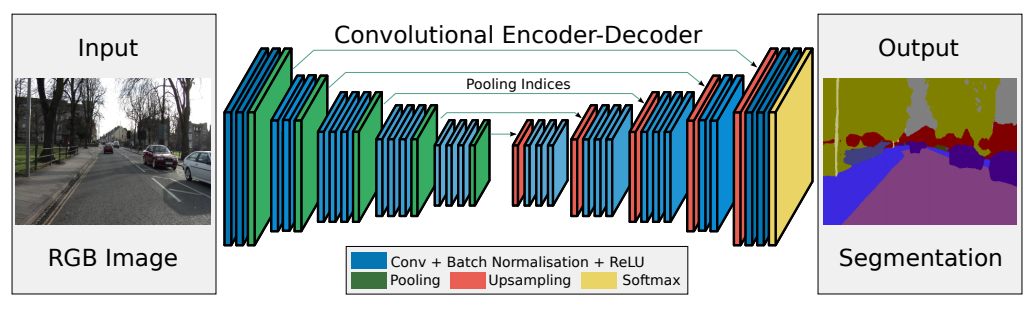

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()

        )
        self.pool0 =  nn.MaxPool2d(kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2)# 64 -> 32
        self.enc_conv3 = nn.Sequential(

            nn.Conv2d(256,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),  

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()              
        )      
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            
             nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),  

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.UpsamplingBilinear2d(scale_factor=2),

             nn.Conv2d(512,512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),  

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()

        )

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),            

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()


        ) 
        self.upsample1 = nn.UpsamplingBilinear2d(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),            

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                        
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            

            nn.Conv2d(128,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                        
            nn.Conv2d(64,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64,1, kernel_size=3, padding=1),
            
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0 = self.pool0(e0)
        e1 = self.enc_conv1(e0)
        e1 = self.pool1(e1)
        e2 = self.enc_conv2(e1)
        e2 = self.pool2(e2)
        e3 = self.enc_conv3(e2)
        e3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b)
        d0 = self.dec_conv0(d0)
        d1 = self.upsample0(d0)
        d1 = self.dec_conv1(d1)
        d2 = self.upsample0(d1)
        d2 = self.dec_conv2(d2)
        d3 = self.upsample0(d2)
        d3 = F.sigmoid(self.dec_conv3(d3)) # no activation
        return d3

In [ ]:
from torchsummary import summary

In [ ]:
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


**IOU metric**

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## BCE Loss Function [1 балл]


$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
 Simplier one:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean(y_pred - y_real*y_pred + torch.log(1+torch.exp(-y_pred))).cuda()

## Training [1 балл]


In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().to('cpu') # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray') #bug!!!
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()


## Inference [1 балл]



In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.cuda())
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Let's train it



In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = SegNet().to(device)

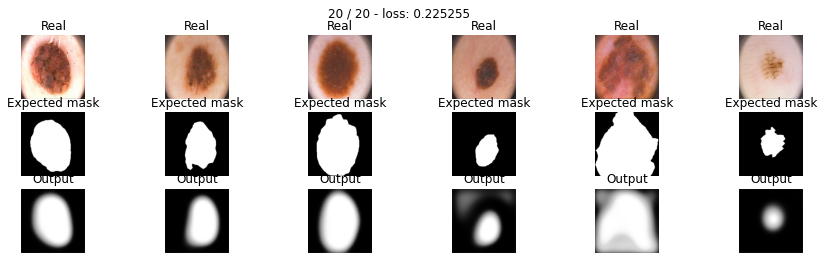

In [ ]:
max_epochs = 20
optimizer = optim.Adam(model.parameters())
train(model, optimizer, nn.BCELoss(), max_epochs, data_tr, data_val)

In [ ]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

## Additional loss functions [2 балла] 

**1. Dice coefficient:** :

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$



$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$



In [ ]:
def dice_loss(y_real, y_pred):

    inputs = y_pred.contiguous().view(y_pred.shape[0], -1)
    targets =y_real = y_real.contiguous().view(y_real.shape[0], -1)
    intersection = (inputs * targets).sum() 
    dice = (2.*intersection + 0.0001)/(inputs.sum() + targets.sum() + 0.0001)   
    return 1 - dice 

In [ ]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

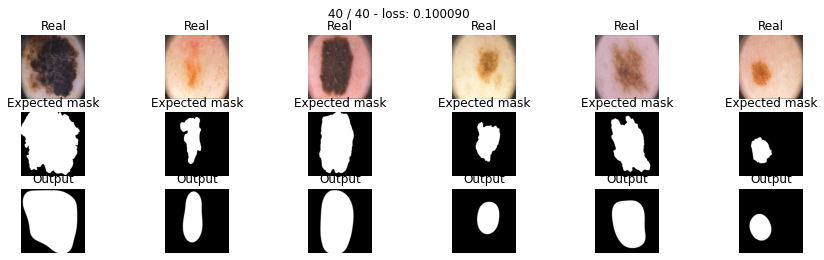

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Set $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
   # y_pred =  # hint: torch.clamp
    y_pred = y_pred.contiguous().view(y_pred.shape[0], -1)
    y_real = y_real.contiguous().view(y_real.shape[0], -1)
    pt = y_real*y_pred + (1-y_real)*(1-y_pred)
    loss = (1-pt)**gamma * torch.log(pt+eps)
    return -loss.mean()
    


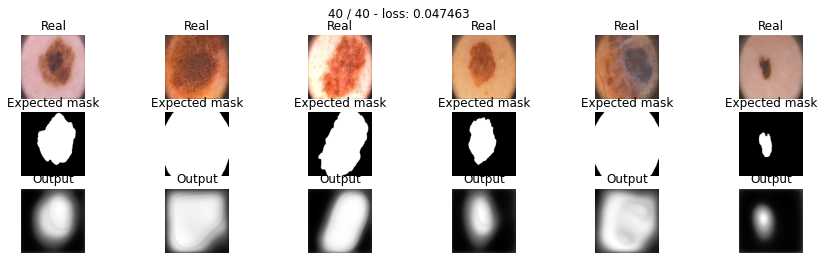

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

-----------------------------------------------------------------------------------------

# U-Net implementation [2 балла]


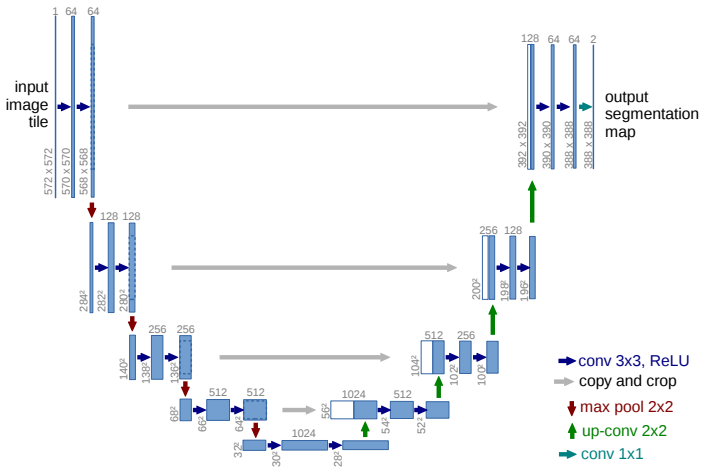


* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
def down_up_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size = 3, padding = 1),
      nn.ReLU(),
      nn.Conv2d(out_c, out_c, kernel_size = 3, padding = 1),
      nn.ReLU()
  )
  return conv

In [ ]:
def crop(tensor, target_tensor): 
  target_size = target_tensor.size()[2]
  tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size - delta, delta:tensor_size - delta]


In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = down_up_conv(3,64)
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride = 2)  # 256 -> 128
        self.enc_conv1 = down_up_conv(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 128 -> 64
        self.enc_conv2 = down_up_conv(128, 256)
        self.pool2 =nn.MaxPool2d(kernel_size = 2, stride = 2)  # 64 -> 32
        self.enc_conv3 = down_up_conv(256,512)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = down_up_conv(512, 1024)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(1024,512, kernel_size = 2, stride = 2) # 16 -> 32
        self.dec_conv0 = down_up_conv(1024, 512)
        self.upsample1 =  nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)# 32 -> 64
        self.dec_conv1 = down_up_conv(512, 256)
        self.upsample2 = nn.ConvTranspose2d(256,128, kernel_size = 2, stride = 2)  # 64 -> 128
        self.dec_conv2 = down_up_conv(256,128)
        self.upsample3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)  # 128 -> 256
        self.dec_conv3 =down_up_conv(128,64)
        self.out = nn.Conv2d(64,1, kernel_size = 1)

    def forward(self, x):
        # encoder
        
        e01 = self.enc_conv0(x)
        e02 = self.pool0(e01)
        e11 = self.enc_conv1(e02)
        e12 = self.pool1(e11)
        e21 = self.enc_conv2(e12)
        e22 = self.pool2(e21)
        e31 = self.enc_conv3(e22)
        e32 = self.pool3(e31)
                  
  

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(e32))

        # decoder
        y0 = crop(e31,b)
        d0 = self.dec_conv0(torch.cat([b, y0], 1))
        d0 = self.upsample1(d0)
        y1 = crop(e21,d0)
        d1 = self.dec_conv1(torch.cat([d0, y1], 1))
        d1 = self.upsample2(d1)
        y2 = crop(e11,d1)
        d2 = self.dec_conv2(torch.cat([d1, y2], 1))
        d2 = self.upsample3(d2)
        y3 = crop(e01,d2)
        d3 = self.dec_conv3(torch.cat([d2, y3], 1))

        d3 = self.out(d3)       
        return d3

In [ ]:
unet_model = UNet().to(device)

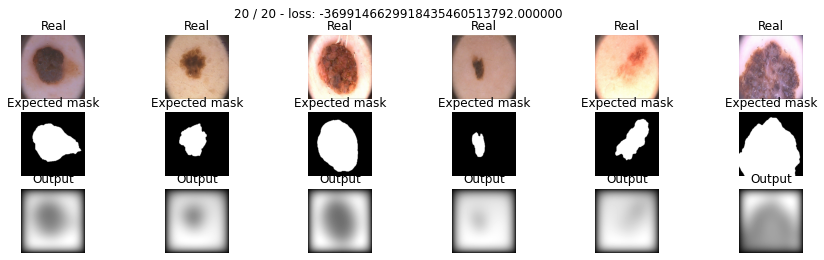

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = down_up_conv(3,64)
        self.pool0 = nn.MaxPool2d(kernel_size = 3, stride = 2)  # 256 -> 128
        self.enc_conv1 = down_up_conv(64, 128)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2) # 128 -> 64
        self.enc_conv2 = down_up_conv(128, 256)
        self.pool2 =nn.MaxPool2d(kernel_size = 3, stride = 2)  # 64 -> 32
        self.enc_conv3 = down_up_conv(256,512)
        self.pool3 = nn.MaxPool2d(kernel_size = 3, stride = 2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = down_up_conv(512, 1024)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(512) # 16 -> 32
        self.dec_conv0 = down_up_conv(1024, 512)
        self.upsample1 =  nn.Upsample(scale_factor=0.5)# 32 -> 64
        self.dec_conv1 = down_up_conv(512, 256)
        self.upsample2 = nn.Upsample(256)  # 64 -> 128
        self.dec_conv2 = down_up_conv(256,128)
        self.upsample3 = nn.Upsample(128)  # 128 -> 256
        self.dec_conv3 =down_up_conv(128,64)
        self.out = nn.Conv2d(64,1, kernel_size = 1)

    def forward(self, x):
        # encoder
        
        e01 = self.enc_conv0(x)
        e02 = self.pool0(e01)
        e11 = self.enc_conv1(e02)
        e12 = self.pool1(e11)
        e21 = self.enc_conv2(e12)
        e22 = self.pool2(e21)
        e31 = self.enc_conv3(e22)
        e32 = self.pool3(e31)
                  
  

        # bottleneck
        b = self.upsample0(self.bottleneck_conv(e32))

        # decoder
        y0 = crop(e31,b)
        d0 = self.dec_conv0(torch.cat([b, y0], 1))
        d0 = self.upsample1(d0)
        y1 = crop(e21,d0)
        d1 = self.dec_conv1(torch.cat([d0, y1], 1))
        d1 = self.upsample2(d1)
        y2 = crop(e11,d1)
        d2 = self.dec_conv2(torch.cat([d1, y2], 1))
        d2 = self.upsample3(d2)
        y3 = crop(e01,d2)
        d3 = self.dec_conv3(torch.cat([d2, y3], 1))

        d3 = self.out(d3)       
        return d3


In [ ]:
unet2_model = UNet2().to(device)
